In [1]:
import inspect
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import arviz as az

import numpyro
import numpyro.distributions as dist
import numpyro.infer.initialization as init

from numpyro.infer.reparam import CircularReparam, LocScaleReparam
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoDiagonalNormal, AutoIAFNormal

import jax
import jax.numpy as jnp

from jax import random, vmap

from jax.config import config

# Run with 64-bit precision (alternatively, scale model parameters)
config.update("jax_enable_x64", True)

# Set number of parallel chains and host device count (CPU is seen as 1 device by JAX)
NUM_CHAINS = 10
numpyro.set_host_device_count(NUM_CHAINS)

In [2]:
track = pd.read_csv('../examples/data/modes.csv')
track.head()

,frac_age,delta_nu_fit,nu_max,nu_0_1,nu_0_2,nu_0_3,nu_0_4,nu_0_5,nu_0_6,nu_0_7,...,nu_0_32,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,surface_he4
0,0.000016,11.884045,150.680452,0.0,34.481794,49.329712,63.195077,75.913367,87.630758,99.483102,...,392.064627,403.710370,415.297909,426.924218,438.655667,450.550178,462.546781,474.658899,486.825847,0.239966
1,0.000017,12.140476,154.893200,0.0,35.203007,50.376320,64.548471,77.583389,89.569246,101.679667,...,400.620086,412.538305,424.386957,436.252351,448.212638,460.326691,472.558635,484.919720,497.325734,0.239967
2,0.000017,12.343045,158.238356,0.0,35.772049,51.202159,65.616199,78.900744,91.100159,103.413323,...,407.368711,419.505074,431.563921,443.619056,455.762984,468.048949,480.469626,493.018551,505.616340,0.239968
3,0.000018,12.503403,160.898485,0.0,36.222266,51.855582,66.460893,79.942765,92.312228,104.785371,...,412.708426,425.019262,437.245702,449.452226,461.742276,474.164224,486.734715,499.427290,512.179364,0.239969
4,0.000018,12.633487,163.061612,0.0,36.587368,52.385499,67.145867,80.787635,93.295718,105.898357,...,417.037759,429.491253,441.854064,454.184875,466.594022,479.127384,491.819429,504.626946,517.505773,0.239969


In [3]:
# profile = track.loc[track['frac_age'] < 0.5].iloc[-1]
profile = track.loc[600]

In [4]:
nu_index = [f'nu_0_{i}' for i in range(10, 30)]

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

In [5]:
n = np.arange(10, 30)

In [6]:
# Scaling relation nu_max
nu_max_sca = profile['nu_max']
print('nu_max ~', round(nu_max_sca, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
delta_nu_fit = profile['delta_nu_fit']
print('delta_nu ~', round(delta_nu_fit, 2), 'muHz')

nu_max ~ 2853.19 muHz
delta_nu ~ 128.7 muHz


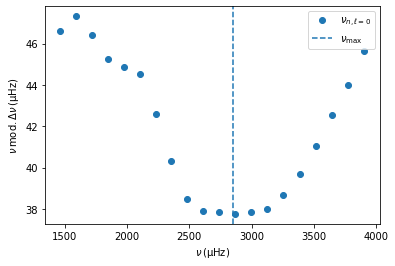

In [7]:
nu_mod = nu % delta_nu_fit

fig, ax = plt.subplots()

ax.plot(nu, nu_mod, 'o', label=r'$\nu_{n,\ell = 0}$')
ax.axvline(nu_max_sca, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [8]:
def asy_background(n, epsilon, alpha, delta_nu, nu_max):
    n_max = nu_max / delta_nu - epsilon
    return delta_nu * (n + epsilon + 0.5 * alpha * (n - n_max)**2)

def glitch(nu, tau, phi, lib=jnp):
    return lib.sin(4 * np.pi * tau * nu + phi)
    
def he_amplitude(nu, b0, b1, lib=jnp):
    return b0 * nu * lib.exp(- b1 * nu**2)

def he_glitch(nu, b0, b1, tau_he, phi_he, lib=jnp):
    return he_amplitude(nu, b0, b1, lib=lib) * glitch(nu, tau_he, phi_he, lib=lib)

def cz_amplitude(nu, c0):
    return c0 / nu**2

def cz_glitch(nu, c0, tau_cz, phi_cz, lib=jnp):
    return cz_amplitude(nu, c0) * glitch(nu, tau_cz, phi_cz, lib=lib)

def average_he_amplitude(b0, b1, low, high, lib=jnp):
    ''' Derived average amplitude over the fitting range.'''
    return b0 * (lib.exp(-b1*low**2) - lib.exp(-b1*high**2)) / (2*b1*(high - low))

In [9]:
from jax.numpy import float64

In [10]:
_epsilon = [1.3, 0.2]
_alpha = [np.log(0.001), 1.0]
_delta_nu = [delta_nu_fit, 1.0]
_nu_max = [nu_max_sca, 0.05*nu_max_sca]

def model_asy(n, nu, nu_err=None):
    epsilon = numpyro.sample('epsilon', dist.Normal(*_epsilon))
    alpha = numpyro.sample('alpha', dist.LogNormal(*_alpha))
    delta_nu = numpyro.sample('delta_nu', dist.Normal(*_delta_nu))
    nu_max = numpyro.sample('nu_max', dist.Normal(*_nu_max))
    
    if nu_err is None:
        nu_err = numpyro.sample('nu_err', dist.HalfNormal(0.5))
    
    nu_model = asy_background(n, epsilon, alpha, delta_nu, nu_max)
    
    nu_obs = numpyro.sample('nu_obs', dist.Normal(nu_model, nu_err), obs=nu)

Numpyro makes use of random keys. We can create a random key and then split it every time we wish to use one.

In [11]:
num_warmup, num_samples = 2000, 2000
rng_key = random.PRNGKey(53)
rng_keys = random.split(rng_key, NUM_CHAINS)

In [12]:
kernel = NUTS(model_asy, target_accept_prob=0.8, init_strategy=init.init_to_median)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=NUM_CHAINS)
mcmc.run(rng_keys, n, nu)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [13]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.00      0.00      0.00      0.00      0.00   9073.97      1.00
  delta_nu    128.70      0.21    128.69    128.37    129.04   4519.54      1.00
   epsilon      1.30      0.04      1.30      1.24      1.36   4468.86      1.00
    nu_err      1.23      0.17      1.22      0.96      1.48   8187.57      1.00
    nu_max   2854.85    137.99   2854.56   2619.74   3071.86   4631.06      1.00

Number of divergences: 0


In [14]:
mcmc.get_samples()

{'alpha': DeviceArray([0.00125584, 0.00126776, 0.00122655, ..., 0.00146939,
              0.00149724, 0.00139657], dtype=float64),
 'delta_nu': DeviceArray([128.47747934, 128.51728576, 128.49341904, ..., 129.02980521,
              128.62495825, 128.80249978], dtype=float64),
 'epsilon': DeviceArray([1.33870561, 1.3310451 , 1.33534071, ..., 1.24082763,
              1.3105251 , 1.27904732], dtype=float64),
 'nu_err': DeviceArray([1.33949313, 1.38085101, 1.4035642 , ..., 1.0980172 ,
              1.06659456, 1.15126221], dtype=float64),
 'nu_max': DeviceArray([2769.8507325 , 2691.59962016, 2690.00386028, ...,
              3064.02292305, 2801.06678398, 2972.20217526], dtype=float64)}

In [15]:
trace_asy = az.from_numpyro(mcmc)

In [16]:
az.summary(trace_asy)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.001,0.000,0.001,0.002,0.000,0.000,9216.0,8524.0,1.0
delta_nu,128.696,0.205,128.295,129.069,0.003,0.002,4541.0,5846.0,1.0
epsilon,1.300,0.036,1.232,1.366,0.001,0.000,4520.0,5761.0,1.0
nu_err,1.228,0.165,0.930,1.534,0.002,0.001,8578.0,8266.0,1.0
nu_max,2854.849,137.988,2595.493,3116.166,2.026,1.435,4637.0,6369.0,1.0


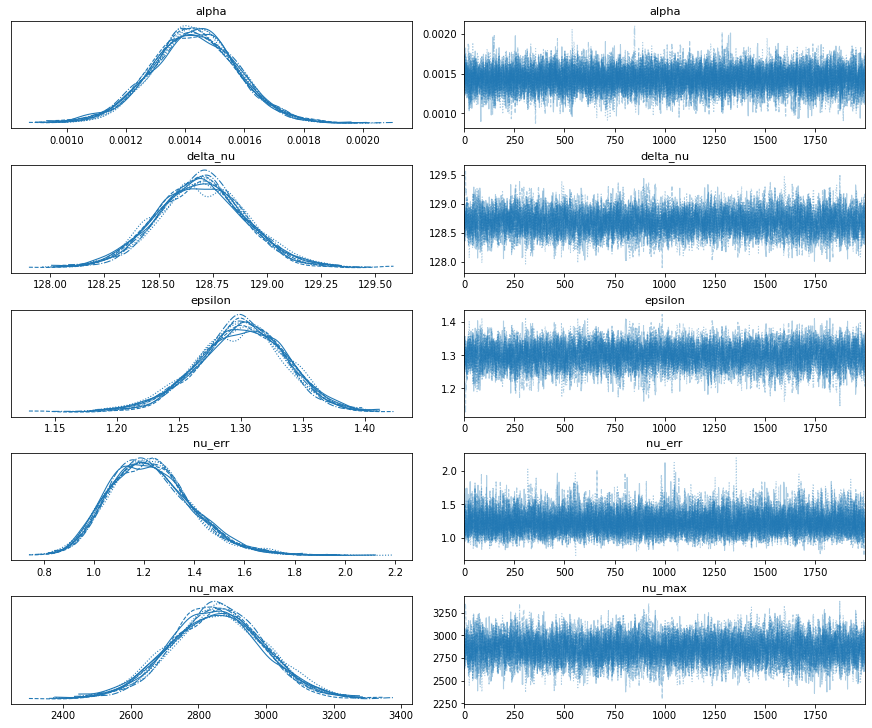

In [17]:
az.plot_trace(trace_asy, compact=True);

In [18]:
nu_model = asy_background(n[:, np.newaxis, np.newaxis], 
                          *trace_asy.posterior[['epsilon', 'alpha', 'delta_nu', 'nu_max']].to_array().values)

In [19]:
nu_model_16 = np.quantile(nu_model, .16, axis=(1, 2))
nu_model_med = np.median(nu_model, axis=(1, 2))
nu_model_84 = np.quantile(nu_model, .84, axis=(1, 2))

nu_model_err = [nu_model_med - nu_model_16, nu_model_84 - nu_model_med]

In [20]:
nu_err = trace_asy.posterior['nu_err'].values

In [21]:
nu_err_16 = np.quantile(nu_err, .16)
nu_err_med = np.median(nu_err)
nu_err_84 = np.quantile(nu_err, .84)

nu_err_err = [nu_err_med - nu_err_16, nu_err_84 - nu_err_med]

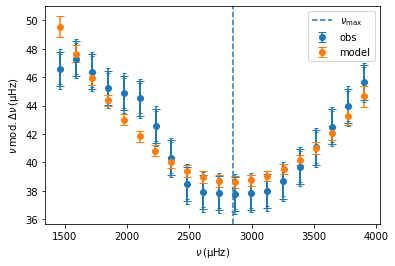

In [22]:
fig, ax = plt.subplots()

# Observed
ax.errorbar(nu, nu % delta_nu_fit, yerr=nu_err_med, fmt='o', capsize=4, label=r'obs')

# Upper and lower limits on the error
ax.errorbar(nu, nu % delta_nu_fit, yerr=nu_err_16, fmt='none', capsize=2)
ax.errorbar(nu, nu % delta_nu_fit, yerr=nu_err_84, fmt='none', capsize=2)

# Model
ax.errorbar(nu_model_med, nu_model_med % delta_nu_fit, yerr=nu_model_err, fmt='o', capsize=4, label='model')

ax.axvline(nu_max_sca, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [13]:
m_tau = 1.05

@handlers.reparam(config={
    'phi_he': CircularReparam()
})
def model_he_glitch(n, nu, nu_err=None):
    epsilon = numpyro.sample('epsilon', dist.Normal(*_epsilon))
    alpha = numpyro.sample('alpha', dist.LogNormal(*_alpha))
    delta_nu = numpyro.sample('delta_nu', dist.Normal(*_delta_nu))
    nu_max = numpyro.sample('nu_max', dist.Normal(*_nu_max))
    
    b0 = numpyro.sample('b0', dist.LogNormal(np.log(1/_nu_max[0]), 1.0))
    b1 = numpyro.sample('b1', dist.LogNormal(np.log(1/_nu_max[0]**2), 1.0))
        
    tau_he = numpyro.sample('tau_he', dist.LogNormal(-m_tau*np.log(_nu_max[0]), 1.0))
    
    phi_he = numpyro.sample('phi_he', dist.VonMises(0.0, 0.1))

    if nu_err is None:
        nu_err = numpyro.sample('nu_err', dist.HalfNormal(0.5))
    
    nu_asy = asy_background(n, epsilon, alpha, delta_nu, nu_max)

    nu_model = nu_asy + he_glitch(nu_asy, b0, b1, tau_he, phi_he)
    
    nu_obs = numpyro.sample('nu_obs', dist.Normal(nu_model, nu_err), obs=nu)

In [26]:
model_args = (n, nu)
model_kwargs = {'nu_err': None}

kernel = NUTS(model_he_glitch, target_accept_prob=0.95,
              init_strategy=init.init_to_median)

def postprocess_fn(x):
    x = kernel.postprocess_fn(model_args, model_kwargs)(x)
#     x['phi_he'] = circular_transform(x['phi_he'])
    low = x['nu_max'] - 2*x['delta_nu']
    high = x['nu_max'] + 2*x['delta_nu']
    x['<he_amplitude>'] = average_he_amplitude(x['b0'], x['b1'], low, high)
    x['he_amplitude_nu_max'] = he_amplitude(x['nu_max'], x['b0'], x['b1'])
    x['nu_asy'] = asy_background(model_args[0], x['epsilon'], x['alpha'], x['delta_nu'], x['nu_max'])
    x['nu_model'] = x['nu_asy'] + he_glitch(x['nu_asy'], x['b0'], x['b1'], x['tau_he'], x['phi_he'])
    return x

In [27]:
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=NUM_CHAINS, 
            postprocess_fn=postprocess_fn)
mcmc.run(rng_keys, *model_args, **model_kwargs)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [28]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
             alpha      0.00      0.00      0.00      0.00      0.00   4030.63      1.00
                b0      0.00      0.00      0.00      0.00      0.01   5590.25      1.00
                b1      0.00      0.00      0.00      0.00      0.00   4614.51      1.00
          delta_nu    128.79      0.19    128.78    128.50    129.09   4914.81      1.00
           epsilon      1.30      0.03      1.30      1.25      1.35   5004.56      1.00
            nu_err      0.53      0.11      0.52      0.36      0.69   7191.11      1.00
            nu_max   2849.53    142.56   2851.29   2605.99   3071.63   8442.75      1.00
  phi_he_unwrapped      5.11      3.18      4.07      1.25     10.95      6.00      2.46
            tau_he      0.00      0.00      0.00      0.00      0.00   3912.97      1.00

Number of divergences: 1


In [29]:
trace_he_glitch = az.from_numpyro(mcmc)

In [30]:
az.summary(trace_he_glitch).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
<he_amplitude>,3.120,1.310,0.682,5.351,0.020,0.014,4116.0,7281.0,1.0
alpha,0.001,0.000,0.000,0.002,0.000,0.000,4253.0,6314.0,1.0
b0,0.003,0.002,0.001,0.007,0.000,0.000,5569.0,7900.0,1.0
b1,0.000,0.000,0.000,0.000,0.000,0.000,4720.0,7103.0,1.0
delta_nu,128.789,0.186,128.447,129.146,0.003,0.002,5076.0,5751.0,1.0


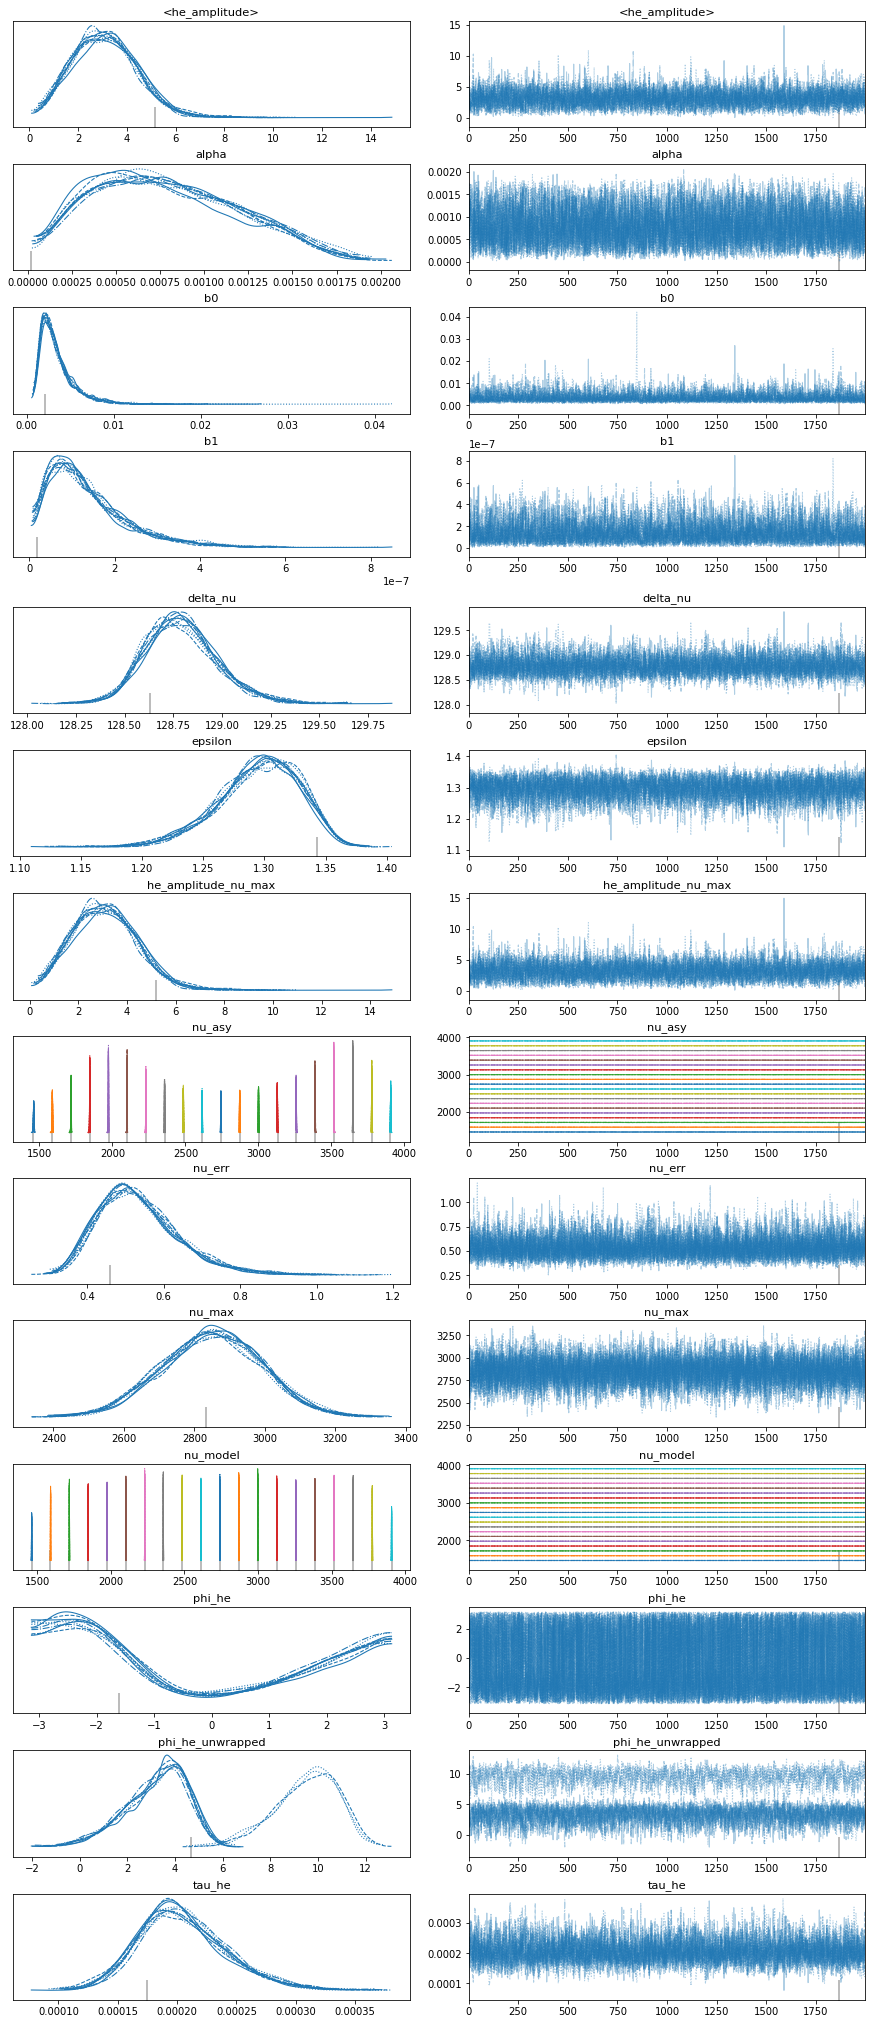

In [31]:
az.plot_trace(trace_he_glitch, compact=True);

## Model He + BCZ glitch

In [14]:
s_tau = 3.0  # Scale factor tau_cz ~ s_tau * tau_he 
log_tau = - m_tau * np.log(_nu_max[0])  # Approx form of log(tau_he)

@handlers.reparam(config={
    'phi_he': CircularReparam(),
    'phi_cz': CircularReparam(),
})
def prior():
    epsilon = numpyro.sample('epsilon', dist.Normal(*_epsilon))
    alpha = numpyro.sample('alpha', dist.LogNormal(*_alpha))
    delta_nu = numpyro.sample('delta_nu', dist.Normal(*_delta_nu))
    nu_max = numpyro.sample('nu_max', dist.Normal(*_nu_max))
    
    b0 = numpyro.sample('b0', dist.LogNormal(np.log(50/_nu_max[0]), 1.0))
    b1 = numpyro.sample('b1', dist.LogNormal(np.log(5/_nu_max[0]**2), 1.0))

    tau_he = numpyro.sample('tau_he', dist.LogNormal(log_tau, 0.8))
    phi_he = numpyro.sample('phi_he', dist.VonMises(0.0, 0.1))

    c0 = numpyro.sample('c0', dist.LogNormal(np.log(0.5*_nu_max[0]**2), 1.0))

    tau_cz = numpyro.sample('tau_cz', dist.LogNormal(log_tau + np.log(s_tau), 0.8))

    # Ensure that tau_cz > tau_he (more stable than tau_cz = tau_he + delta_tau)
    delta_tau_logp = dist.LogNormal(log_tau, 0.8).log_prob(tau_cz - tau_he)
    delta_tau = numpyro.factor('delta_tau', delta_tau_logp)
    
    phi_cz = numpyro.sample('phi_cz', dist.VonMises(0.0, 0.1))
    
    return epsilon, alpha, delta_nu, nu_max, b0, b1, tau_he, phi_he, c0, tau_cz, phi_cz

def model_hecz_glitch(n, nu, nu_err=None):

    epsilon, alpha, delta_nu, nu_max, b0, b1, tau_he, phi_he, c0, tau_cz, phi_cz = prior()

    nu_err = numpyro.sample('nu_err', dist.HalfNormal(0.1))
    
    nu_asy = numpyro.deterministic('nu_asy', asy_background(n, epsilon, alpha, delta_nu, nu_max))

    nu_model = nu_asy + he_glitch(nu_asy, b0, b1, tau_he, phi_he) + cz_glitch(nu_asy, c0, tau_cz, phi_cz)

    nu_obs = numpyro.sample('nu_obs', dist.Normal(nu_model, nu_err), obs=nu)

In [15]:
model_args = (n, nu)
model_kwargs = {'nu_err': None}

In [16]:
kernel = NUTS(model_hecz_glitch, target_accept_prob=0.99,
              init_strategy=init.init_to_median
             )

def postprocess_fn(x):
    x = kernel.postprocess_fn(model_args, model_kwargs)(x)
    low = x['nu_max'] - 2*x['delta_nu']
    high = x['nu_max'] + 2*x['delta_nu']
    x['<he_amplitude>'] = average_he_amplitude(x['b0'], x['b1'], low, high)
    x['he_amplitude_nu_max'] = he_amplitude(x['nu_max'], x['b0'], x['b1'])

    x['nu_asy'] = asy_background(model_args[0], x['epsilon'], x['alpha'], x['delta_nu'], x['nu_max'])
    x['nu_model'] = x['nu_asy'] + he_glitch(x['nu_asy'], x['b0'], x['b1'], x['tau_he'], x['phi_he']) + \
        cz_glitch(x['nu_asy'], x['c0'], x['tau_cz'], x['phi_cz'])

    return x

In [17]:
%%time
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=NUM_CHAINS, 
#             postprocess_fn=postprocess_fn
           )
mcmc.run(rng_keys, *model_args, **model_kwargs)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 7min 20s, sys: 1.24 s, total: 7min 21s
Wall time: 1min 15s


In [18]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
             alpha      0.00      0.00      0.00      0.00      0.00    597.60      1.02
                b0      0.04      0.02      0.03      0.02      0.06    541.76      1.03
                b1      0.00      0.00      0.00      0.00      0.00    780.21      1.02
                c0 3477231.43 351310.26 3485417.85 2906118.02 4040545.55    943.33      1.01
          delta_nu    128.79      0.26    128.79    128.37    129.23    623.96      1.01
           epsilon      1.27      0.05      1.27      1.20      1.35    614.96      1.02
            nu_err      0.15      0.03      0.14      0.10      0.19   1581.62      1.00
            nu_max   2840.04    135.47   2840.09   2614.81   3062.02    737.54      1.01
  phi_cz_unwrapped     -0.37      4.41      0.12     -6.44      6.90      5.07      8.53
  phi_he_unwrapped      2.04      3.03      2.01     -2.98      9.16      6.04      2.47
            tau_

In [19]:
trace_hecz_glitch = az.from_dict(
    posterior=mcmc.get_samples(group_by_chain=True),
    sample_stats=mcmc.get_extra_fields(group_by_chain=True)
)
az.summary(trace_hecz_glitch).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.002,0.000,0.001,0.002,0.000,0.000,674.0,979.0,1.01
b0,0.038,0.017,0.015,0.068,0.001,0.001,565.0,948.0,1.03
b1,0.000,0.000,0.000,0.000,0.000,0.000,731.0,1158.0,1.02
c0,3477231.426,351310.261,2832980.337,4153688.311,11421.857,8078.964,978.0,1236.0,1.01
delta_nu,128.793,0.262,128.300,129.279,0.010,0.007,649.0,1373.0,1.01


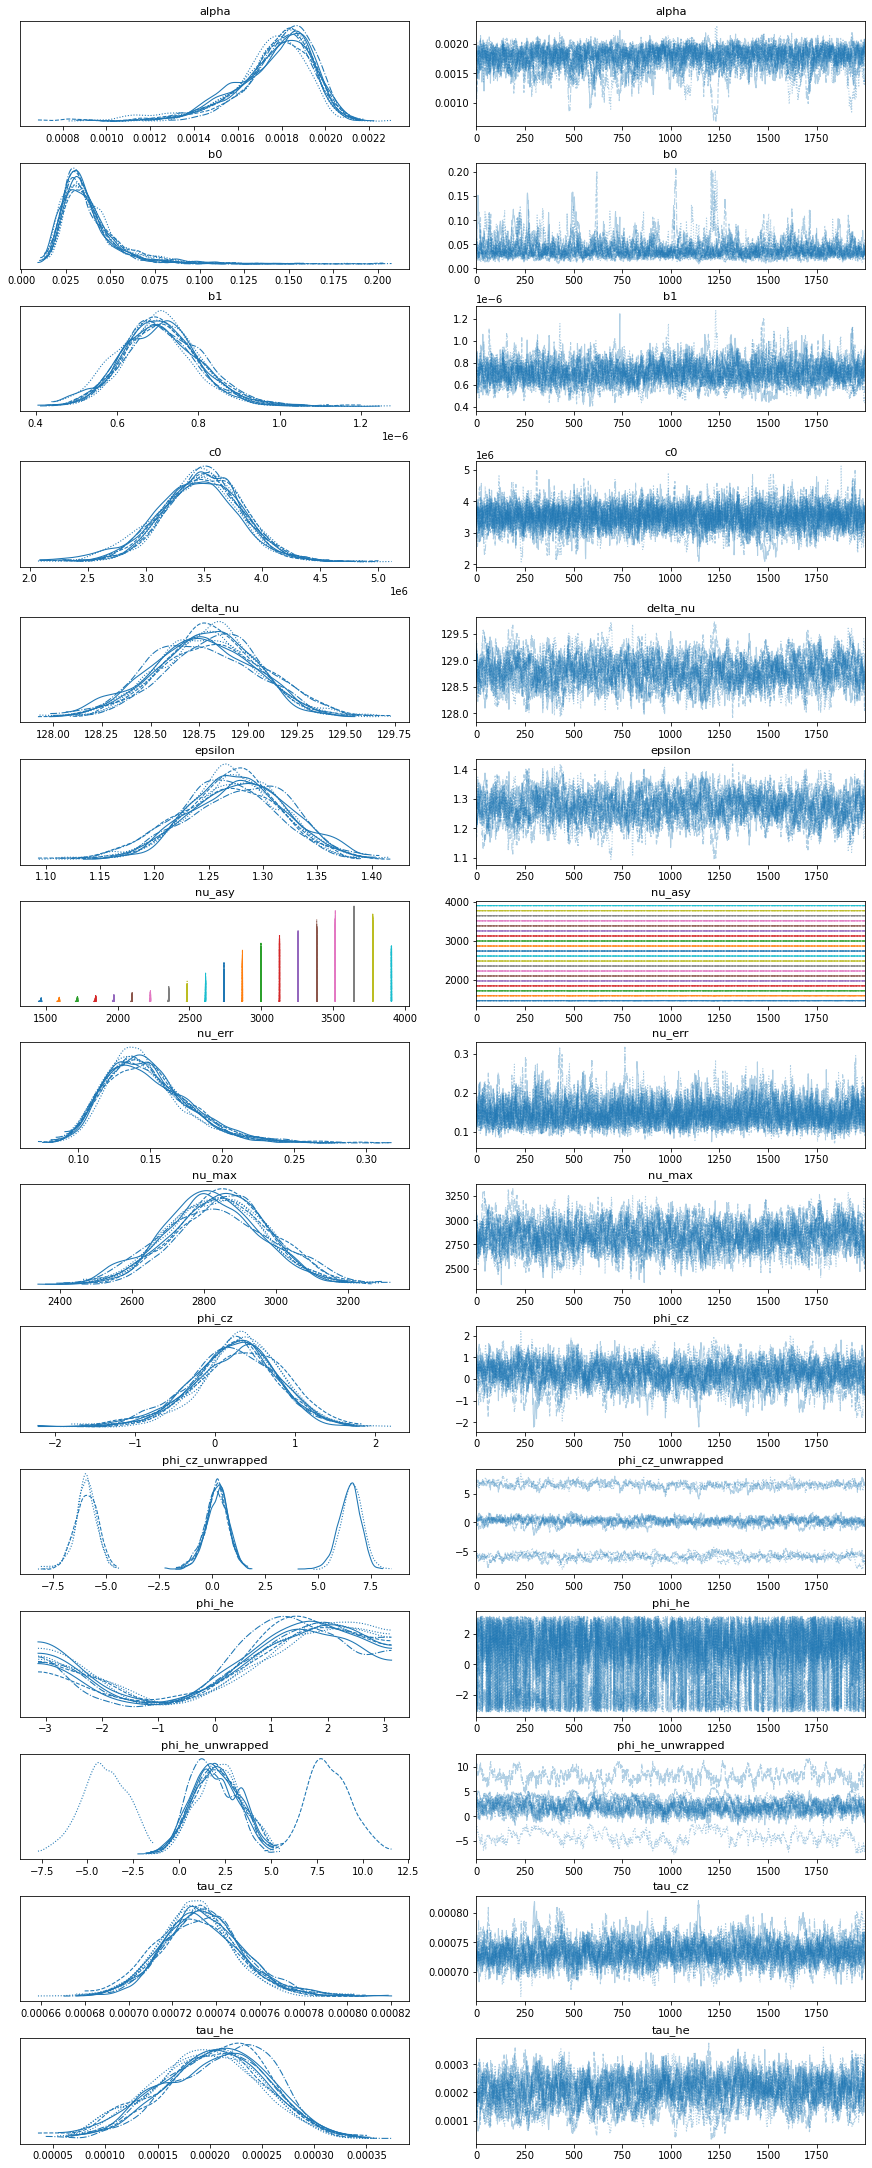

In [20]:
az.plot_trace(trace_hecz_glitch, compact=True);

$$\tau \sim \nu_\max^{-0.95}$$

$$\log(\tau) \sim -0.95 * \log(\nu_\max)$$

In [39]:
samples = mcmc.get_samples()

In [40]:
n_points = 500
nu_fit = np.linspace(nu[0], nu[-1], n_points)
n_fit = np.linspace(n[0], n[-1], n_points)

asy_fit = asy_background(n_fit[:, jnp.newaxis], samples['epsilon'], 
                     samples['alpha'], samples['delta_nu'], samples['nu_max'])

he_glitch_fit = he_glitch(nu_fit[:, jnp.newaxis], samples['b0'], 
                          samples['b1'], samples['tau_he'], samples['phi_he'])
cz_glitch_fit = cz_glitch(nu_fit[:, jnp.newaxis], samples['c0'], 
                          samples['tau_cz'], samples['phi_cz'])

In [41]:
glitch_fit = he_glitch_fit + cz_glitch_fit

In [42]:
glitch_upper = np.quantile(glitch_fit, .84, axis=1)
glitch_median = np.median(glitch_fit, axis=1)
glitch_lower = np.quantile(glitch_fit, .16, axis=1)


In [43]:
asy_med = np.median(samples['nu_asy'], axis=0)
asy_err = [asy_med - np.quantile(samples['nu_asy'], .16, axis=0), 
           np.quantile(samples['nu_asy'], .84, axis=0) - asy_med]

In [44]:
asy_med

array([1465.92988254, 1592.32061697, 1718.93885785, 1845.78980211,
       1972.87196321, 2100.18274575, 2227.72469567, 2355.49650455,
       2483.50173901, 2611.73666566, 2740.19939449, 2868.89045288,
       2997.80915233, 3126.96585812, 3256.36335238, 3385.99707538,
       3515.86371852, 3645.96131419, 3776.28593135, 3906.83640163])

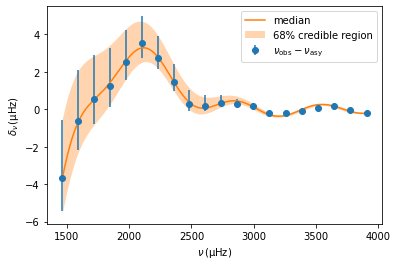

In [45]:
fig, ax = plt.subplots()

ax.errorbar(nu, nu - asy_med, yerr=asy_err[::-1], fmt='o', label=r'$\nu_\mathrm{obs} - \nu_\mathrm{asy}$')

ax.plot(nu_fit, glitch_median, '-', color='C1', label='median')
ax.fill_between(nu_fit, glitch_lower, glitch_upper, color='C1', alpha=0.33, linewidth=0, label='68% credible region')

ax.set_ylabel(r'$\delta_\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [46]:
nu_model_med = np.median(samples['nu_model'], axis=0)
nu_model_err = [nu_model_med - np.quantile(samples['nu_model'], .16, axis=0), 
           np.quantile(samples['nu_model'], .84, axis=0) - nu_model_med]

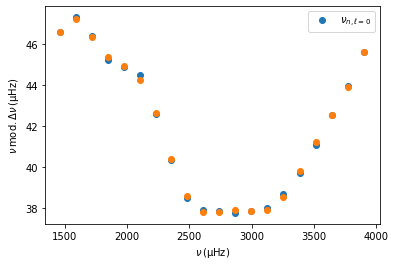

In [47]:
fig, ax = plt.subplots()

ax.plot(nu, nu % delta_nu_fit, 'o', label=r'$\nu_{n,\ell = 0}$')

ax.errorbar(nu_model_med, nu_model_med%delta_nu_fit, yerr=nu_model_err, fmt='o', color='C1')

ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()